In [3]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
data = pd.read_csv("VNM_Historical_Data.csv")
data

,Date,Close,Open,High,Low,Vol.,Change %
0,03-01-17,100082.0,99213.0,100319.0,99213.0,782840,0.88
1,04-01-17,100240.0,100714.0,100793.0,100161.0,791240,0.16
2,05-01-17,100082.0,100398.0,100398.0,99687.0,986830,-0.16
3,06-01-17,99529.0,100082.0,100793.0,99529.0,1650000,-0.55
4,09-01-17,99529.0,100082.0,100161.0,99529.0,1090000,0.00
...,...,...,...,...,...,...,...
1736,14-12-23,68400.0,68400.0,68900.0,68200.0,1460000,0.29
1737,15-12-23,68100.0,68500.0,68600.0,68100.0,3740000,-0.44
1738,18-12-23,67000.0,68100.0,68200.0,67000.0,3510000,-1.62
1739,19-12-23,67000.0,67100.0,67400.0,66300.0,3060000,0.00


In [5]:
# 2. Gắn index với giá Close
data1 = data.reset_index()['Close']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [7]:
# 4. Chia train test theo tỉ lệ 7:2:1
train_size = int(0.7 * len(data1))
test_size = int(0.2 * len(data1))
val_size = len(data1) - train_size - test_size

train_data = data1[:train_size]
test_data = data1[train_size:train_size+test_size]
val_data = data1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [11]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

18/18 [==============================] - 18s 471ms/step - loss: 0.0479 - val_loss: 0.0049
Epoch 2/100
18/18 [==============================] - 4s 206ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 3/100
18/18 [==============================] - 4s 243ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 4/100
18/18 [==============================] - 3s 171ms/step - loss: 0.0029 - val_loss: 8.9677e-04
Epoch 5/100
18/18 [==============================] - 3s 173ms/step - loss: 0.0026 - val_loss: 9.5328e-04
Epoch 6/100
18/18 [==============================] - 3s 170ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 7/100
18/18 [==============================] - 3s 145ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 8/100
18/18 [==============================] - 3s 145ms/step - loss: 0.0023 - val_loss: 9.0273e-04
Epoch 9/100
18/18 [==============================] - 3s 147ms/step - loss: 0.0022 - val_loss: 7.5148e-04
Epoch 10/100
18/18 [==============================] - 3s 151ms/step - los

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 44ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 73219.45505963403
Testing RMSE: 74123.93637201219


In [16]:
# Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 73125.78385597192
Testing MAE: 74016.96814873749


In [17]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval)) * 100
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 87043092.54729377
Testing MAPE: inf


C:\Users\ngomi\AppData\Local\Temp\ipykernel_4396\77519784.py:3: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100


In [20]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=114
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.10706897 0.10356996 0.10531946 0.09657193 0.09744668 0.09919619
 0.09919619 0.10706897 0.10794373 0.11581651 0.12019028 0.12631355
 0.14118436 0.14643289 0.12893781 0.12981257 0.09919619 0.1026952
 0.11931552 0.11581651 0.10356996 0.10356996 0.10706897 0.10619422
 0.1009457  0.10356996 0.10794373 0.10531946 0.10182045 0.10007094
 0.10706897 0.11756602 0.11931552 0.14555813 0.14118436 0.14468338
 0.14468338 0.16480271 0.16392796 0.15955419 0.16392796 0.15955419
 0.16655222 0.15605518 0.15867944 0.15955419 0.15430567 0.15430567
 0.14905715 0.14643289 0.14205912 0.14293387 0.12981257 0.13418633
 0.11844077 0.11319225 0.1254388  0.11144274 0.11494175 0.10007094
 0.11319225 0.10881848 0.11494175 0.11494175 0.12456404 0.12718831
 0.12193978 0.11844077 0.11056799 0.08869915 0.09657193 0.0782021
 0.07907685 0.06770506 0.05020998 0.05895752 0.05545851 0.05895752
 0.07995161 0.08432538 0.07645259 0.08520013 0.08345062 0.08869915
 0.08257587 0.07295358 0.0650808  0.0668303  0.08257

In [21]:
# 14. Kết quả dự báo 30 ngày tiếp theo
y_future = scaler.inverse_transform(lst_output)
y_future

array([[68659.90573   ],
       [68785.83470948],
       [69051.50780572],
       [69372.1646373 ],
       [69708.7565739 ],
       [70045.52907826],
       [70376.23893483],
       [70698.1094884 ],
       [71009.70215901],
       [71310.25549581],
       [71599.48501942],
       [71877.48271716],
       [72144.62420407],
       [72401.4699216 ],
       [72648.69870231],
       [72887.04303808],
       [73117.2141274 ],
       [73339.88569245],
       [73555.6607614 ],
       [73765.0478199 ],
       [73968.4676249 ],
       [74166.24553906],
       [74358.61834464],
       [74545.74020563],
       [74727.71588539],
       [74904.58456372],
       [75076.35305451],
       [75243.00943346],
       [75404.51537251],
       [75560.83169186]])

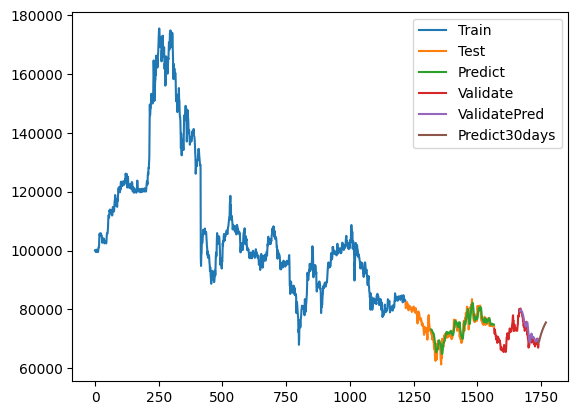

In [22]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(data1)-1, stop=len(data1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()